In [19]:
#参考https://github.com/kumar-shridhar/ProbAct-Probabilistic-Activation-Function/blob/master/VGG_ReLU.ipynb

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.optim import Adam
import torchvision
import torchvision.transforms as transforms
import os

In [2]:
# VGG16 Model Definition with Layers Defined Explicitly
class VGG16(nn.Module):
    def __init__(self, nclass):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            # Conv Layer Block 1
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Conv Layer Block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Conv Layer Block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Conv Layer Block 4
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Conv Layer Block 5
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Dropout Layer
            nn.Dropout(0.5)
        )
        
        self.classifier = nn.Linear(512, nclass)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x, None  # Return None to be compatible with other variations

# Configuration
lr = 0.01
data = 'cifar10'
root = './data/'
model_out = './checkpoint/cifar10_vgg16.pth'
resume = False

nclass = 10

In [3]:
# Data transformations
transform_train = transforms.Compose([
    #transforms.RandomCrop(32, padding=4),
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Datasets and dataloaders
trainset = torchvision.datasets.CIFAR10(root=root, train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True, num_workers=8)

testset = torchvision.datasets.CIFAR10(root=root, train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=8)

# Model initialization
net = VGG16(nclass).cuda()
net = nn.DataParallel(net)

# Resume from a checkpoint if needed
if resume:
    print(f'==> Resuming from {model_out}')
    checkpoint = torch.load(model_out)
    net.load_state_dict(checkpoint['net'])
    start_epoch = checkpoint['epoch'] + 1
else:
    start_epoch = 0

cudnn.benchmark = True
criterion = nn.CrossEntropyLoss()
optimizer = Adam(net.parameters(), lr=lr)

# Training function
def train(epoch):
    print('Epoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.cuda(), targets.cuda()
        optimizer.zero_grad()
        outputs, _ = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    print(f'[TRAIN] Acc: {100.*correct/total:.3f}, Loss: {train_loss/len(trainloader):.3f}')

# Testing function
def test(epoch):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs, _ = net(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    print(f'[TEST] Acc: {100.*correct/total:.3f}, Loss: {test_loss/len(testloader):.3f}')

    # Save checkpoint after each epoch
    state = {
        'net': net.state_dict(),
        'epoch': epoch,
    }
    os.makedirs(os.path.dirname(model_out), exist_ok=True)
    torch.save(state, model_out)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# Main training loop
epochs = [50, 50]
count = start_epoch

for epoch_len in epochs:
    optimizer = Adam(net.parameters(), lr=lr)
    for _ in range(epoch_len):
        train(count)
        test(count)
        count += 1
    lr /= 10

Epoch: 0
[TRAIN] Acc: 10.466, Loss: 2.495
[TEST] Acc: 10.610, Loss: 2.301
Epoch: 1
[TRAIN] Acc: 11.212, Loss: 2.330
[TEST] Acc: 12.260, Loss: 2.250
Epoch: 2
[TRAIN] Acc: 22.708, Loss: 1.957
[TEST] Acc: 30.150, Loss: 1.842
Epoch: 3
[TRAIN] Acc: 37.008, Loss: 1.617
[TEST] Acc: 42.430, Loss: 1.589
Epoch: 4
[TRAIN] Acc: 53.466, Loss: 1.267
[TEST] Acc: 53.830, Loss: 1.340
Epoch: 5
[TRAIN] Acc: 66.266, Loss: 0.952
[TEST] Acc: 66.240, Loss: 0.977
Epoch: 6
[TRAIN] Acc: 73.514, Loss: 0.769
[TEST] Acc: 58.980, Loss: 1.230
Epoch: 7
[TRAIN] Acc: 78.180, Loss: 0.645
[TEST] Acc: 74.460, Loss: 0.746
Epoch: 8
[TRAIN] Acc: 81.356, Loss: 0.552
[TEST] Acc: 78.980, Loss: 0.632
Epoch: 9
[TRAIN] Acc: 84.282, Loss: 0.472
[TEST] Acc: 73.990, Loss: 0.808
Epoch: 10
[TRAIN] Acc: 86.294, Loss: 0.410
[TEST] Acc: 75.150, Loss: 0.805
Epoch: 11
[TRAIN] Acc: 88.420, Loss: 0.346
[TEST] Acc: 79.430, Loss: 0.653
Epoch: 12
[TRAIN] Acc: 90.182, Loss: 0.297
[TEST] Acc: 70.650, Loss: 1.165
Epoch: 13
[TRAIN] Acc: 91.574, Loss

In [5]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.optim import Adam
import torchvision
import torchvision.transforms as transforms
import os
import math

# Custom GELU Activation Function
class GELU(nn.Module):
    def __init__(self):
        super(GELU, self).__init__()
        self.sigma = nn.Parameter(torch.randn(1))  # Learnable parameter sigma 

    def forward(self, input):
        temp2 = input / 2 * (1 + torch.erf(input / math.sqrt(2) / self.sigma))
        return temp2

# VGG16 Model Definition with GELU Activation Function
class VGG16Gelu(nn.Module):
    def __init__(self, nclass):
        super(VGG16Gelu, self).__init__()
        self.features = nn.Sequential(
            # Conv Layer Block 1
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            GELU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            GELU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Conv Layer Block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            GELU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            GELU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Conv Layer Block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            GELU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            GELU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            GELU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Conv Layer Block 4
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            GELU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            GELU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            GELU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Conv Layer Block 5
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            GELU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            GELU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            GELU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Dropout Layer
            nn.Dropout(0.5)
        )
        
        self.classifier = nn.Linear(512, nclass)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x, None  # Return None to be compatible with other variations

# Configuration
lr = 0.01
data = 'cifar10'
root = './data/'
model_out = './checkpoint/cifar10_vgg16.pth'
resume = False

nclass = 10

# Data transformations
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Datasets and dataloaders
trainset = torchvision.datasets.CIFAR10(root=root, train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root=root, train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=4)

# Model initialization
netgelu = VGG16Gelu(nclass).cuda()
netgelu = nn.DataParallel(netgelu)

# Resume from a checkpoint if needed
if resume:
    print(f'==> Resuming from {model_out}')
    checkpoint = torch.load(model_out)
    netgelu.load_state_dict(checkpoint['netgelu'])
    start_epoch = checkpoint['epoch'] + 1
else:
    start_epoch = 0

cudnn.benchmark = True
criterion = nn.CrossEntropyLoss()

# Training function
def train(epoch):
    print('Epoch: %d' % epoch)
    netgelu.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.cuda(), targets.cuda()
        optimizer.zero_grad()
        outputs, _ = netgelu(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    print(f'[TRAIN] Acc: {100.*correct/total:.3f}, Loss: {train_loss/len(trainloader):.3f}')

# Testing function
def test(epoch):
    netgelu.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs, _ = netgelu(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    print(f'[TEST] Acc: {100.*correct/total:.3f}, Loss: {test_loss/len(testloader):.3f}')

    # Save checkpoint after each epoch
    state = {
        'netgelu': netgelu.state_dict(),
        'epoch': epoch,
    }
    os.makedirs(os.path.dirname(model_out), exist_ok=True)
    torch.save(state, model_out)

# Main training loop
epochs = [50, 50]
count = start_epoch

for epoch_len in epochs:
    optimizer = Adam(netgelu.parameters(), lr=lr)
    for _ in range(epoch_len):
        train(count)
        test(count)
        count += 1
    lr /= 10

Files already downloaded and verified
Files already downloaded and verified
Epoch: 0
[TRAIN] Acc: 23.650, Loss: 1.958
[TEST] Acc: 30.110, Loss: 1.807
Epoch: 1
[TRAIN] Acc: 35.864, Loss: 1.644
[TEST] Acc: 39.480, Loss: 1.563
Epoch: 2
[TRAIN] Acc: 51.194, Loss: 1.344
[TEST] Acc: 54.630, Loss: 1.290
Epoch: 3
[TRAIN] Acc: 60.900, Loss: 1.120
[TEST] Acc: 64.950, Loss: 1.004
Epoch: 4
[TRAIN] Acc: 67.374, Loss: 0.946
[TEST] Acc: 66.490, Loss: 0.965
Epoch: 5
[TRAIN] Acc: 72.170, Loss: 0.814
[TEST] Acc: 67.790, Loss: 0.992
Epoch: 6
[TRAIN] Acc: 75.858, Loss: 0.720
[TEST] Acc: 74.520, Loss: 0.758
Epoch: 7
[TRAIN] Acc: 78.784, Loss: 0.636
[TEST] Acc: 76.960, Loss: 0.744
Epoch: 8
[TRAIN] Acc: 80.882, Loss: 0.579
[TEST] Acc: 79.380, Loss: 0.664
Epoch: 9
[TRAIN] Acc: 82.492, Loss: 0.533
[TEST] Acc: 80.160, Loss: 0.639
Epoch: 10
[TRAIN] Acc: 84.032, Loss: 0.492
[TEST] Acc: 81.840, Loss: 0.574
Epoch: 11
[TRAIN] Acc: 85.316, Loss: 0.450
[TEST] Acc: 81.590, Loss: 0.604
Epoch: 12
[TRAIN] Acc: 86.290, Los

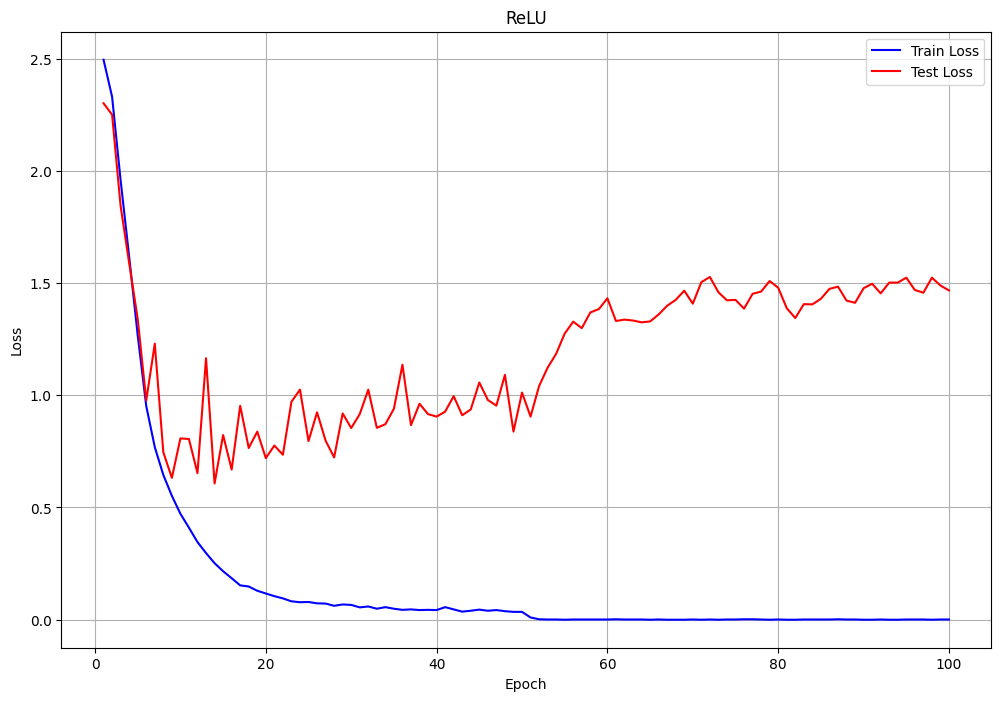

In [8]:
import matplotlib.pyplot as plt

# 提供的训练损失和测试损失数据
train_loss = [2.495, 2.330, 1.957, 1.617, 1.267, 0.952, 0.769, 0.645, 0.552, 0.472, 0.410, 0.346, 0.297, 0.252, 0.216, 0.185, 
              0.153, 0.148, 0.129, 0.117, 0.105, 0.095, 0.082, 0.078, 0.079, 0.073, 0.072, 0.062, 0.068, 0.066, 0.055, 0.059, 
              0.049, 0.056, 0.049, 0.044, 0.046, 0.043, 0.044, 0.043, 0.056, 0.046, 0.036, 0.040, 0.045, 0.040, 0.043, 0.038, 
              0.035, 0.035, 0.010, 0.002, 0.001, 0.001, 0.000, 0.001, 0.001, 0.001, 0.001, 0.001, 0.002, 0.001, 0.001, 0.001, 
              0.000, 0.001, 0.000, 0.000, 0.000, 0.001, 0.000, 0.001, 0.000, 0.001, 0.001, 0.002, 0.002, 0.001, 0.000, 0.001, 
              0.000, 0.000, 0.001, 0.001, 0.001, 0.001, 0.002, 0.001, 0.001, 0.000, 0.000, 0.001, 0.000, 0.000, 0.001, 0.001, 
              0.001, 0.000, 0.001, 0.001]

test_loss = [2.301, 2.250, 1.842, 1.589, 1.340, 0.977, 1.230, 0.746, 0.632, 0.808, 0.805, 0.653, 1.165, 0.607, 0.823, 0.669, 
             0.953, 0.765, 0.838, 0.720, 0.776, 0.735, 0.971, 1.025, 0.796, 0.924, 0.798, 0.723, 0.919, 0.854, 0.916, 1.025, 
             0.855, 0.871, 0.940, 1.136, 0.867, 0.962, 0.916, 0.905, 0.927, 0.996, 0.911, 0.937, 1.057, 0.979, 0.954, 1.091, 
             0.838, 1.012, 0.905, 1.041, 1.123, 1.185, 1.275, 1.328, 1.299, 1.369, 1.384, 1.432, 1.331, 1.337, 1.333, 1.325, 
             1.329, 1.360, 1.399, 1.425, 1.466, 1.408, 1.504, 1.527, 1.459, 1.423, 1.425, 1.386, 1.452, 1.462, 1.509, 1.479, 
             1.388, 1.344, 1.406, 1.405, 1.430, 1.474, 1.484, 1.422, 1.412, 1.477, 1.497, 1.454, 1.502, 1.502, 1.524, 1.469, 
             1.457, 1.524, 1.489, 1.467]

# 生成x轴数据，表示epoch数量
epochs = list(range(1, len(test_loss) + 1))

# 绘制训练损失和测试损失随epoch变化的图表
plt.figure(figsize=(12, 8))
plt.plot(epochs, train_loss, label='Train Loss', color='b')
plt.plot(epochs, test_loss, label='Test Loss', color='r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ReLU')
plt.legend()
plt.grid(True)
plt.show()


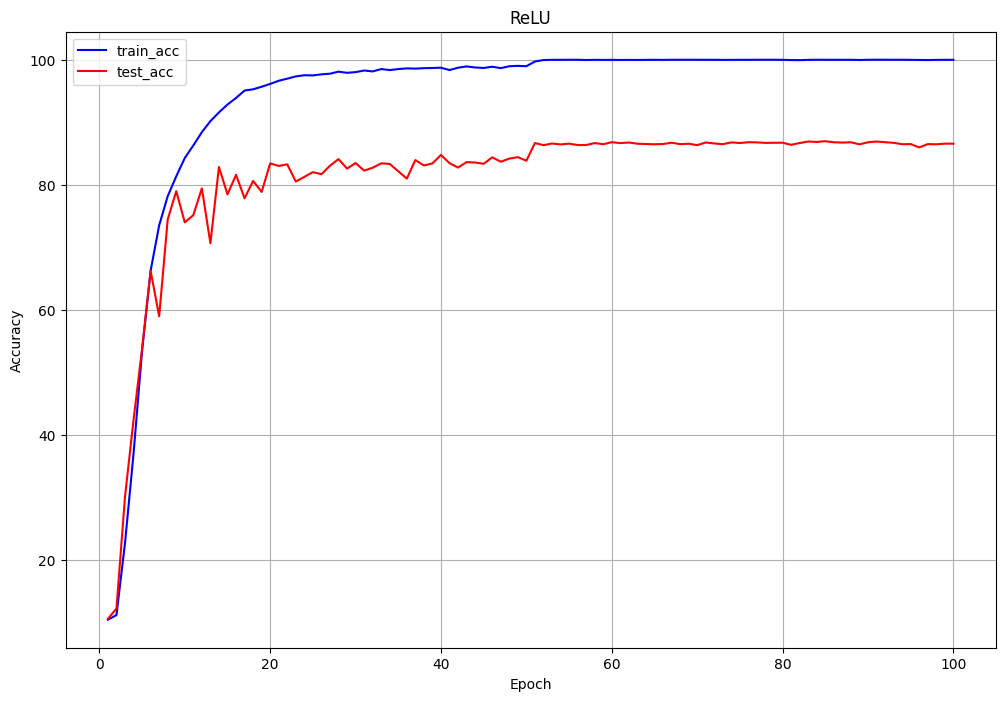

In [10]:
train_acc = [10.466, 11.212, 22.708, 37.008, 53.466, 66.266, 73.514, 78.180, 81.356, 84.282, 86.294, 88.420, 90.182, 91.574, 
             92.832, 93.882, 95.068, 95.268, 95.680, 96.132, 96.634, 96.972, 97.334, 97.516, 97.486, 97.660, 97.762, 98.092, 
             97.904, 98.014, 98.278, 98.126, 98.506, 98.340, 98.504, 98.612, 98.578, 98.646, 98.674, 98.724, 98.344, 98.724, 
             98.926, 98.758, 98.680, 98.878, 98.654, 98.956, 99.016, 98.960, 99.710, 99.948, 99.984, 99.980, 99.992, 99.988, 
             99.952, 99.980, 99.968, 99.976, 99.960, 99.970, 99.964, 99.976, 99.984, 99.972, 99.990, 99.986, 99.996, 99.984, 
             99.986, 99.986, 99.972, 99.974, 99.984, 99.980, 99.994, 99.996, 99.992, 99.980, 99.946, 99.932, 99.974, 99.992, 
             99.984, 99.986, 99.984, 99.986, 99.956, 99.988, 99.998, 99.996, 99.986, 99.992, 99.980, 99.962, 99.946, 99.972, 
             99.982, 99.986]

test_acc = [10.610, 12.260, 30.150, 42.430, 53.830, 66.240, 58.980, 74.460, 78.980, 73.990, 75.150, 79.430, 70.650, 82.850, 
            78.460, 81.600, 77.840, 80.620, 78.860, 83.420, 83.020, 83.270, 80.520, 81.270, 82.030, 81.690, 83.050, 84.110, 
            82.590, 83.480, 82.270, 82.730, 83.430, 83.340, 82.160, 80.990, 83.960, 83.090, 83.420, 84.780, 83.460, 82.750, 
            83.630, 83.560, 83.360, 84.390, 83.690, 84.190, 84.420, 83.850, 86.680, 86.340, 86.600, 86.460, 86.580, 86.350, 
            86.360, 86.670, 86.490, 86.810, 86.670, 86.760, 86.570, 86.520, 86.480, 86.520, 86.730, 86.500, 86.570, 86.340, 
            86.770, 86.610, 86.490, 86.780, 86.680, 86.810, 86.780, 86.700, 86.720, 86.730, 86.390, 86.680, 86.920, 86.850, 
            86.970, 86.800, 86.750, 86.800, 86.470, 86.800, 86.920, 86.810, 86.710, 86.490, 86.510, 85.980, 86.510, 86.480, 
            86.580, 86.570]
epochs = list(range(1, len(train_acc) + 1))

# 绘制训练损失和测试损失随epoch变化的图表
plt.figure(figsize=(12, 8))
plt.plot(epochs, train_acc, label='train_acc', color='b')
plt.plot(epochs, test_acc, label='test_acc', color='r')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('ReLU')
plt.legend()
plt.grid(True)
plt.show()


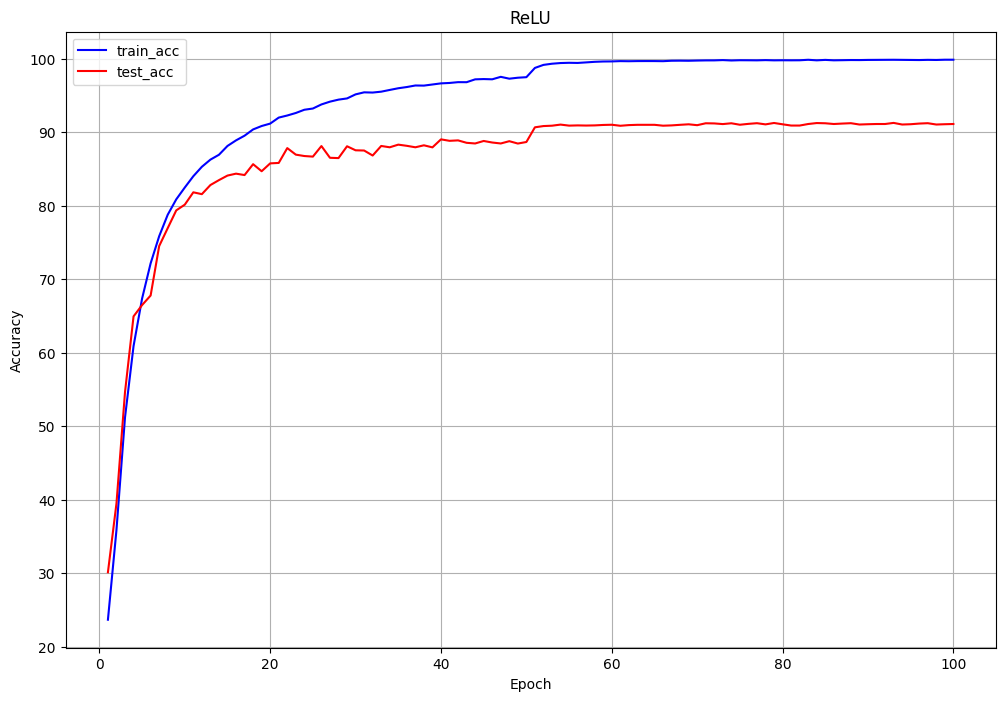

In [16]:
train_loss_gelu = [1.958, 1.644, 1.344, 1.120, 0.946, 0.814, 0.720, 0.636, 0.579, 0.533, 0.492, 0.450, 0.421, 0.398, 0.371, 0.342, 0.321, 0.301, 0.284, 0.269, 0.247, 0.237, 0.226, 0.216, 0.211, 0.191, 0.180, 0.172, 0.167, 0.150, 0.144, 0.142, 0.138, 0.131, 0.121, 0.119, 0.112, 0.114, 0.108, 0.102, 0.099, 0.099, 0.101, 0.087, 0.089, 0.085, 0.074, 0.083, 0.077, 0.077, 0.038, 0.025, 0.021, 0.016, 0.015, 0.017, 0.014, 0.012, 0.011, 0.011, 0.010, 0.010, 0.009, 0.009, 0.009, 0.008, 0.008, 0.008, 0.006, 0.006, 0.006, 0.006, 0.007, 0.006, 0.006, 0.006, 0.005, 0.004, 0.006, 0.005, 0.005, 0.006, 0.006, 0.005, 0.004, 0.005, 0.004, 0.004, 0.004, 0.003, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004]
test_loss_gelu = [1.807, 1.563, 1.290, 1.004, 0.965, 0.992, 0.758, 0.744, 0.664, 0.639, 0.574, 0.604, 0.531, 0.518, 0.504, 0.496, 0.498, 0.472, 0.502, 0.490, 0.485, 0.427, 0.439, 0.462, 0.471, 0.425, 0.481, 0.473, 0.418, 0.448, 0.460, 0.523, 0.427, 0.442, 0.450, 0.454, 0.443, 0.466, 0.490, 0.424, 0.448, 0.432, 0.478, 0.480, 0.466, 0.469, 0.491, 0.467, 0.519, 0.493, 0.450, 0.467, 0.468, 0.477, 0.490, 0.478, 0.482, 0.506, 0.510, 0.518, 0.512, 0.531, 0.531, 0.534, 0.527, 0.522, 0.521, 0.530, 0.522, 0.538, 0.536, 0.548, 0.563, 0.557, 0.562, 0.574, 0.579, 0.561, 0.564, 0.581, 0.569, 0.559, 0.543, 0.566, 0.574, 0.579, 0.576, 0.577, 0.588, 0.578, 0.600, 0.588, 0.584, 0.594, 0.604, 0.580, 0.583, 0.590, 0.599, 0.613]

train_acc_gelu = [23.650, 35.864, 51.194, 60.900, 67.374, 72.170, 75.858, 78.784, 80.882, 82.492, 84.032, 85.316, 86.290, 86.952, 88.152, 88.912, 89.550, 90.402, 90.866, 91.196, 92.012, 92.298, 92.640, 93.080, 93.248, 93.804, 94.184, 94.458, 94.622, 95.174, 95.452, 95.422, 95.542, 95.778, 96.008, 96.174, 96.384, 96.368, 96.520, 96.672, 96.728, 96.838, 96.832, 97.220, 97.258, 97.226, 97.562, 97.310, 97.442, 97.514, 98.776, 99.188, 99.348, 99.440, 99.474, 99.454, 99.528, 99.606, 99.650, 99.662, 99.702, 99.688, 99.706, 99.710, 99.708, 99.694, 99.752, 99.762, 99.750, 99.778, 99.798, 99.802, 99.842, 99.788, 99.822, 99.816, 99.806, 99.838, 99.806, 99.818, 99.810, 99.816, 99.884, 99.808, 99.868, 99.810, 99.828, 99.850, 99.844, 99.864, 99.870, 99.878, 99.884, 99.872, 99.860, 99.848, 99.874, 99.858, 99.892, 99.892]
test_acc_gelu = [30.110, 39.480, 54.630, 64.950, 66.490, 67.790, 74.520, 76.960, 79.380, 80.160, 81.840, 81.590, 82.830, 83.500, 84.120, 84.380, 84.190, 85.670, 84.710, 85.780, 85.840, 87.860, 86.970, 86.780, 86.700, 88.140, 86.540, 86.500, 88.110, 87.560, 87.530, 86.850, 88.150, 87.970, 88.330, 88.170, 87.970, 88.240, 87.960, 89.050, 88.850, 88.910, 88.580, 88.490, 88.830, 88.620, 88.490, 88.800, 88.480, 88.690, 90.690, 90.860, 90.910, 91.060, 90.920, 90.950, 90.930, 90.950, 91.010, 91.040, 90.900, 90.990, 91.030, 91.030, 91.030, 90.910, 90.950, 91.030, 91.100, 90.980, 91.240, 91.220, 91.130, 91.240, 91.040, 91.160, 91.250, 91.090, 91.280, 91.100, 90.930, 90.930, 91.140, 91.270, 91.240, 91.140, 91.200, 91.250, 91.070, 91.110, 91.140, 91.140, 91.290, 91.070, 91.110, 91.200,  91.250,  91.070, 91.110, 91.140]

# 绘制训练损失和测试损失随epoch变化的图表
plt.figure(figsize=(12, 8))
plt.plot(epochs, train_acc_gelu, label='train_acc', color='b')
plt.plot(epochs, test_acc_gelu, label='test_acc', color='r')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('ReLU')
plt.legend()
plt.grid(True)
plt.show()                 

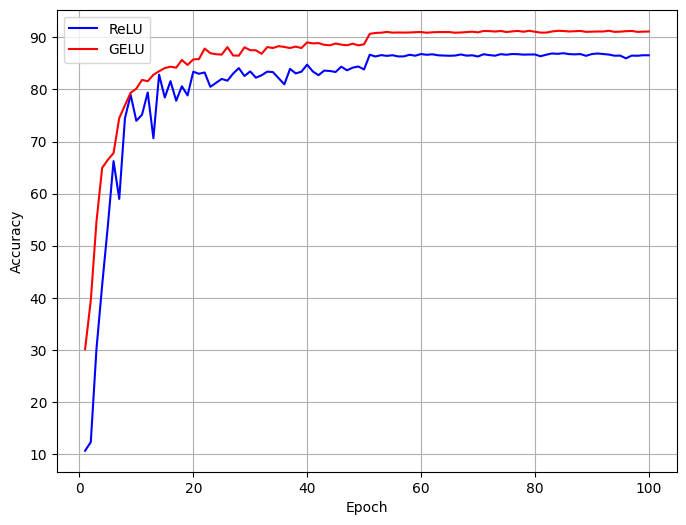

In [18]:
plt.figure(figsize=(8, 6))
plt.plot(epochs, test_acc, label='ReLU', color='b')
plt.plot(epochs, test_acc_gelu, label='GELU', color='r')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()                 